# Problem statement
Example 9.2 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition

In this notebook, we calculate the optimal policy using the on-policy Temporal Difference method (SARSA) with linear function approximation for the mountain car problem.

In [1]:
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
import sys
from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 

from utils import plotting
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

In [3]:
def epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a given action values (Q) approximator and epsilon
    
    @estimator: An estimator that returns action values for a given state
    @epsilon: the probability to select a random action
    @num_actions: number of actions in the environment
    
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action
    
    """
    def policy_fn(observation):
        actions_prob = np.ones(num_actions, dtype=float) * epsilon / num_actions
        action_values = estimator.predict(observation)
        best_action = np.argmax(action_values)
        actions_prob[best_action] += (1.0 - epsilon)
        return actions_prob
    return policy_fn

In [4]:
# A small sample size from the observation space is picked for
# normalizing the features (position and velocity) to 
# zero mean and unit variance
observation_examples = np.array([env.observation_space.sample() for x in range(20000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# This scaler is used to convert a state into a featurized represenation by
# RBF kernels with different variances to cover different parts of the state space
# A total of 400 features is extracted from the states
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [5]:
class ValueFuncEstimator():
    """
    Value Function approximator 
    """
    
    def __init__(self):
        # A separate Stochastic Gradient Descent model for each action in the environment's
        # action space is created
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, state, action=None):
        """
        Makes value function predictions
        
        @state: state to make a prediction for
        @action: (Optional) action to make a prediction for
            
        Returns
            If an action is given, it returns a single number as the prediction
            If no action is provided, it returns a vector of predictions for all actions            
        """
        features = self.featurize_state(state)
        if not action:
            return np.array([x.predict([features])[0] for x in self.models])
        else:
            return self.models[action].predict([features])[0]
    
    def update(self, state, action, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y
        """
        features = self.featurize_state(state)
        self.models[action].partial_fit([features], [y])

In [6]:
def sarsa(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    TD(0) off-policy control (Q-learning) using function approximation to find the optimal policy
    
    @env: OpenAI environment
    @estimator: action-Value function estimator
    @num_episodes: number of episodes to sample
    @discount_factor: Gamma discount factor
    @alpha: TD learning rate
    @epsilon: the probability to select a random action
    @epsilon_decay: epsilon decay rate
    
    Returns:
        EpisodeStats object containing episode_lengths and episode_rewards
    """
    
    # Keeps track of episodes length and rewards
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # Behavior policy is the epsilon-greedy policy
        policy = epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        state = env.reset()
        
        # Pick an action to start SARSA
        action_probs = policy(state)
        next_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        for t in itertools.count():
            
            action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            action_values_next = estimator.predict(next_state)
            
            # In SARSA, target policy is the behaviour policy
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            td_target = reward + discount_factor * action_values_next[next_action]
            
            # Update the function approximator using the target
            estimator.update(state, action, td_target)
            
            print(f"\rStep {t} @ Episode {i_episode + 1}/{num_episodes} (reward = {last_reward})", end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [7]:
estimator = ValueFuncEstimator()
stats = sarsa(env, estimator, 200, epsilon=0.05)

Step 140 @ Episode 200/200 (reward = -111.0)

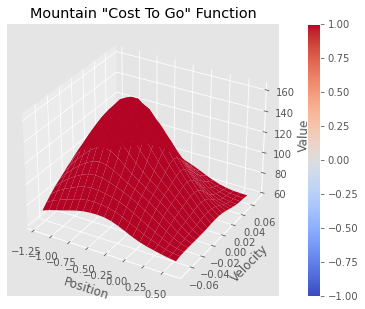

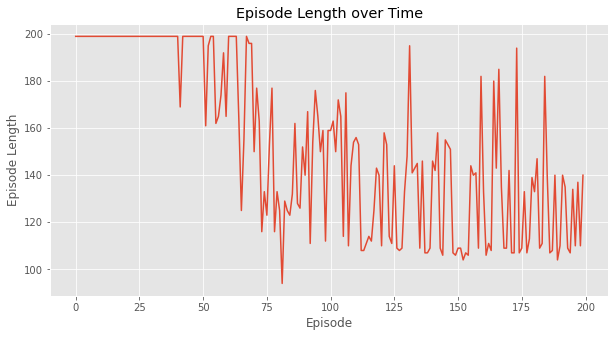

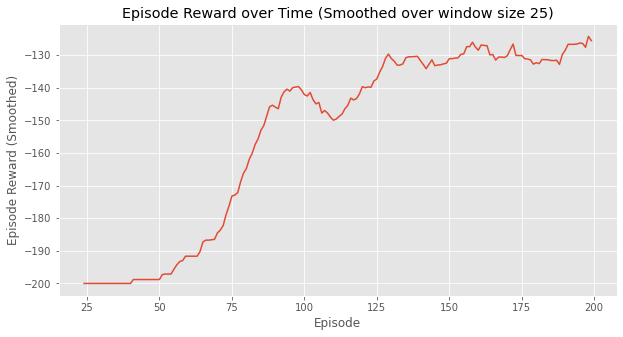

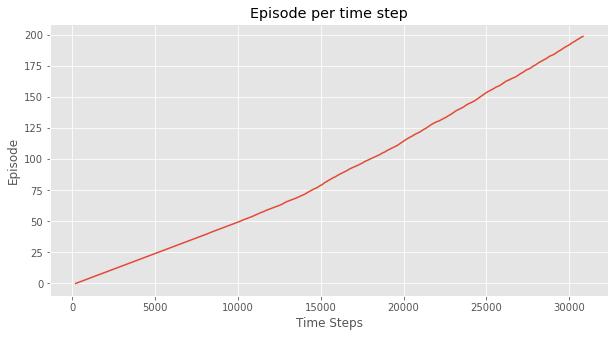

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)